# Psychoacoustic Perceptual Loss Function Demo

## Install libraries

## Import Libraries

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from numpy.fft import fft, ifft
import torch.nn as nn
import math
torch.pi = math.pi

## Signal Processing Parameters


In [6]:
# Signal Processing Parameters

fs = 48000 # [Hz]
maxfreq=fs/2
duration = 2 # [s]
n_fft = 2**17
alpha=0.8  #Exponent for non-linear superposition of spreading functions
nfilts=64  #number of subbands in the bark domain


## Signals

In [7]:
# Sinusoids
x1=torch.sin(2*torch.pi/n_fft*2404*torch.arange(n_fft))
x2=torch.sin(2*torch.pi/n_fft*(2404+2000)*torch.arange(n_fft))*0.005
x3=torch.sin(2*torch.pi/n_fft*(2404+4000)*torch.arange(n_fft))*0.002

In [8]:
# Noise mT in Silence
def noisefromdBSpectrum(spec,fs):
    #produces noise according to the dB spectrum given in spec
    #Spectrum goes from frequency 0 up to Nyquist frequency
    specvoltage=10.0**(spec/20.0)
    #produce 40 blocks of sound:
    #Noise in the range of -1...+1, and Multiply noise with spectrum:
    noisespec=specvoltage*(np.random.rand(len(specvoltage))-0.5)*2
    #make spectrum symmetric for ifft: 
    #trick: Append zeros to fill up negative frequencies in upper half of DFT, then take real part of inverse transform:
    noisespec=np.concatenate((noisespec, np.zeros(len(noisespec))))
    noise_ifft=np.real(ifft(noisespec,norm='ortho'))
    noise=noise_ifft
    return (noise, fs)

f=np.linspace(0,fs/2,n_fft//2)
LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.)),-20,60)
#LTQ=(3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.))
#LTQ/=np.abs(LTQ).max()
#Shift dB according to our internal representation:
LTQ=LTQ-60
#Play back noise shaped like the masking theshold in quoet:
#Normalize
shaped_noise_mT, fs = noisefromdBSpectrum(LTQ,fs)
shaped_noise_mT/=np.abs(shaped_noise_mT).max()

C:\Users\Fera\AppData\Local\Temp\ipykernel_5692\705418744.py:17: RuntimeWarning: divide by zero encountered in power
  LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.)),-20,60)


In [9]:
# Signals X and Y in Time
x = x1.float()
y = (x1 + x2 + x3 + shaped_noise_mT*2).float()

In [13]:
# Signals X and Y in Frequency
freqs = torch.fft.rfftfreq(n_fft)*fs
x_fft_mag = 20*torch.log(torch.abs(torch.fft.rfft(x,norm='ortho'))+1e-12)
y_fft_mag = 20*torch.log(torch.abs(torch.fft.rfft(y,norm='ortho'))+1e-12)

In [20]:
import plotly.express as px
fig = px.line(x=freqs, y=x_fft_mag, title='Life expectancy in Canada')
fig.show()

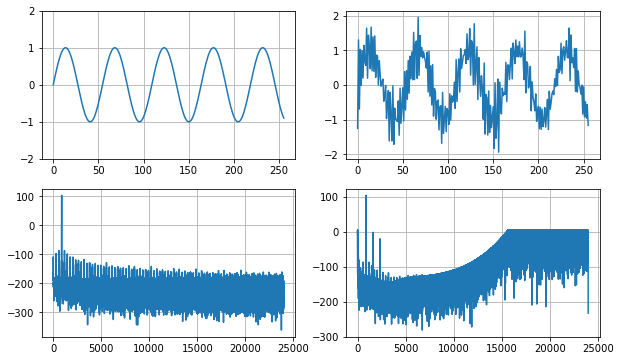

In [14]:
plt.figure(figsize=(10,6))
plt.subplot(2, 2, 1)
plt.plot(x.detach()[:256])
plt.ylim([-2,2])
plt.grid()
plt.subplot(2, 2, 2)
plt.plot(y.detach()[:256])
plt.grid()
plt.subplot(2, 2, 3)
plt.plot(freqs, x_fft_mag)
plt.grid()
plt.subplot(2, 2, 4)
plt.plot(freqs, y_fft_mag)
plt.grid()

In [21]:
# Playback
print('x')
display(ipd.Audio(x.detach(),rate=fs))
print('y')
display(ipd.Audio(y.detach(),rate=fs))

x


y


## Psychoacoustic Model Functions

In [ ]:
def hz2bark_torch(f):
        """ Usage: Bark=hz2bark(f)
            f    : (ndarray)    Array containing frequencies in Hz.
        Returns  :
            Brk  : (ndarray)    Array containing Bark scaled values.
        """
        if not torch.is_tensor(f):
          f = torch.tensor(f)

        Brk = 6. * torch.arcsinh(f/600.)                                           
        return Brk

In [ ]:
def bark2hz_torch(Brk):
        """ Usage:
        Hz=bark2hs(Brk)
        Args     :
            Brk  : (ndarray)    Array containing Bark scaled values.
        Returns  :
            Fhz  : (ndarray)    Array containing frequencies in Hz.
        """
        if not torch.is_tensor(Brk):
          Brk = torch.tensor(Brk)
        Fhz = 600. * torch.sinh(Brk/6.)
        return Fhz

In [ ]:
def mapping2barkmat_torch(fs, nfilts,nfft):
  #Constructing mapping matrix W which has 1's for each Bark subband, and 0's else
  #usage: W=mapping2barkmat(fs, nfilts,nfft)  
  #arguments: fs: sampling frequency
  #nfilts: number of subbands in Bark domain
  #nfft: number of subbands in fft
  maxbark=hz2bark_torch(fs/2) #upper end of our Bark scale:22 Bark at 16 kHz
  nfreqs=nfft/2; step_bark = maxbark/(nfilts-1)
  binbark = hz2bark_torch(torch.linspace(0,(nfft/2),(nfft//2)+1)*fs/nfft)
  W = torch.zeros((nfilts, nfft))
  for i in range(nfilts):
     W[i,0:int(nfft/2)+1] = (torch.round(binbark/step_bark)== i)
  return W

In [ ]:
def mapping2bark_torch(mX,W,nfft):
  #Maps (warps) magnitude spectrum vector mX from DFT to the Bark scale
  #arguments: mX: magnitude spectrum from fft
  #W: mapping matrix from function mapping2barkmat
  #nfft: : number of subbands in fft
  #returns: mXbark, magnitude mapped to the Bark scale
  nfreqs=int(nfft/2)
  #Here is the actual mapping, suming up powers and conv. back to Voltages:
  mXbark = (torch.matmul( torch.abs(mX[:nfreqs])**2.0, W[:, :nfreqs].T))**(0.5)
  return mXbark

In [ ]:
def mappingfrombarkmat_torch(W,nfft):
  #Constructing inverse mapping matrix W_inv from matrix W for mapping back from bark scale
  #usuage: W_inv=mappingfrombarkmat(Wnfft)
  #argument: W: mapping matrix from function mapping2barkmat
  #nfft: : number of subbands in fft
  nfreqs=int(nfft/2)
  W_inv= torch.matmul(torch.diag((1.0/(torch.sum(W,1)+1e-6))**0.5), W[:,0:nfreqs + 1]).T
  return W_inv

In [ ]:
def mappingfrombark_torch(mTbark,W_inv,nfft):
  #usage: mT=mappingfrombark(mTbark,W_inv,nfft)
  #Maps (warps) magnitude spectrum vector mTbark in the Bark scale
  # back to the linear scale
  #arguments:
  #mTbark: masking threshold in the Bark domain
  #W_inv : inverse mapping matrix W_inv from matrix W for mapping back from bark scale
  #nfft: : number of subbands in fft
  #returns: mT, masking threshold in the linear scale
  nfreqs=int(nfft/2)
  mT = torch.matmul(mTbark, W_inv[:, :nfreqs].T.float())
  return mT

In [ ]:
def f_SP_dB_torch(maxfreq,nfilts):
   #usage: spreadingfunctionmatdB=f_SP_dB(maxfreq,nfilts)
   #computes the spreading function protoype, in the Bark scale.
   #Arguments: maxfreq: half the sampling freqency
   #nfilts: Number of subbands in the Bark domain, for instance 64   
   maxbark=hz2bark_torch(maxfreq) #upper end of our Bark scale:22 Bark at 16 kHz
   #Number of our Bark scale bands over this range: nfilts=64
   spreadingfunctionBarkdB=torch.zeros(2*nfilts)
   #Spreading function prototype, "nfilts" bands for lower slope 
   spreadingfunctionBarkdB[0:nfilts]=torch.linspace(-maxbark*27,-8,nfilts)-23.5
   #"nfilts" bands for upper slope:
   spreadingfunctionBarkdB[nfilts:2*nfilts]=torch.linspace(0,-maxbark*12.0,nfilts)-23.5
   return spreadingfunctionBarkdB

In [ ]:
def spreadingfunctionmat_torch(spreadingfunctionBarkdB,alpha,nfilts):
   #Turns the spreading prototype function into a matrix of shifted versions.
   #Convert from dB to "voltage" and include alpha exponent
   #nfilts: Number of subbands in the Bark domain, for instance 64  
   spreadingfunctionBarkVoltage=10.0**(spreadingfunctionBarkdB/20.0*alpha)
   #Spreading functions for all bark scale bands in a matrix:
   spreadingfuncmatrix=torch.zeros((nfilts,nfilts))
   for k in range(nfilts):
      spreadingfuncmatrix[k,:]=spreadingfunctionBarkVoltage[(nfilts-k):(2*nfilts-k)]
   return spreadingfuncmatrix

In [ ]:
def maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,alpha,fs,nfilts): 
  #Computes the masking threshold on the Bark scale with non-linear superposition
  #usage: mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
  #Arg: mXbark: magnitude of FFT spectrum, on the Bark scale
  #spreadingfuncmatrix: spreading function matrix from function spreadingfunctionmat
  #alpha: exponent for non-linear superposition (eg. 0.6), 
  #fs: sampling freq., nfilts: number of Bark subbands
  #nfilts: Number of subbands in the Bark domain, for instance 64  
  #Returns: mTbark: the resulting Masking Threshold on the Bark scale 
  
  #Compute the non-linear superposition:
  mTbark=torch.matmul(mXbark**alpha, spreadingfuncmatrix**alpha)
  #apply the inverse exponent to the result:
  mTbark=mTbark**(1.0/alpha)
  #Threshold in quiet:
  maxfreq=fs/2.0
  maxbark=hz2bark_torch(maxfreq)
  step_bark = maxbark/(nfilts-1)
  barks=torch.arange(0,nfilts)*step_bark
  #convert the bark subband frequencies to Hz:
  f=bark2hz_torch(barks)+1e-6
  #Threshold of quiet in the Bark subbands in dB:
  LTQ=torch.clip((3.64*(f/1000.)**-0.8 -6.5*torch.exp(-0.6*(f/1000.-3.3)**2.)
      +1e-3*((f/1000.)**4.)),-20,120)
  #Maximum of spreading functions and hearing threshold in quiet:
  a = mTbark
  b = 10.0**((LTQ-60)/20)
  mTbark=torch.max(a,b)
  return mTbark

## Psychoacoustic Loss Function

In [ ]:
class PsychoAcousticLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_fft = 2048, return_complex= False, 
                 n_filts = 64, fs = 48000, alpha=0.8, type = "mse_time"):
        super(PsychoAcousticLoss, self).__init__()
        self.n_fft = n_fft
        self.return_complex = return_complex
        self.n_filts = n_filts
        self.fs = fs
        self.maxfreq=fs//2
        self.alpha = alpha
 
    def forward(self, x, y):
      # Compute STFT of x
      x_stft = torch.stft(x, self.n_fft, return_complex = self.return_complex)
      x_stft_mt = torch.zeros_like(x_stft)
      # Compute mT for every Block
      n_frames = x_stft.shape[1]
      W = mapping2barkmat_torch(self.fs, self.n_filts,self.n_fft)
      spreadingfunctionBarkdB=f_SP_dB_torch(self.maxfreq,self.n_filts)
      spreadingfuncmatrix=spreadingfunctionmat_torch(spreadingfunctionBarkdB,self.alpha, self.n_filts)
      for frame in range(n_frames):
        stft_frame = x_stft[:,frame,0]
        mXbark=mapping2bark_torch(stft_frame,W,self.n_fft)
        mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,self.alpha,self.fs,self.n_filts)
        W_inv = mappingfrombarkmat_torch(W,self.n_fft)
        mT=mappingfrombark_torch(mTbark,W_inv,self.n_fft)
        x_stft_mt[:,frame,0]=stft_frame * mT**-1
      
      # Compute STFT of Y
      y_stft = torch.stft(y, self.n_fft, return_complex = self.return_complex)
      y_stft_mt = torch.zeros_like(y_stft)
      # Compute mT for every Block
      n_frames = y_stft.shape[1]
      W = mapping2barkmat_torch(self.fs, self.n_filts,self.n_fft)
      spreadingfunctionBarkdB=f_SP_dB_torch(self.maxfreq,self.n_filts)
      spreadingfuncmatrix=spreadingfunctionmat_torch(spreadingfunctionBarkdB,self.alpha, self.n_filts)
      for frame in range(n_frames):
        stft_frame = y_stft[:,frame,0]
        mXbark=mapping2bark_torch(stft_frame,W,self.n_fft)
        mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,self.alpha,self.fs,self.n_filts)
        W_inv = mappingfrombarkmat_torch(W,self.n_fft)
        mT=mappingfrombark_torch(mTbark,W_inv,self.n_fft)
        y_stft_mt[:,frame,0]=stft_frame * mT**-1
        
      if type == "mse_frequency":
        x = y_stft_mt.flatten()
        y = x_stft_mt.flatten()
        mse = torch.nn.MSELoss()
        return mse(x,y)

      # Compute ISTFT of x
      x_istft = torch.istft(x_stft_mt, self.n_fft, return_complex = self.return_complex)
      # Compute ISTFT of y
      y_istft = torch.istft(y_stft_mt, self.n_fft, return_complex = self.return_complex)

      # Compute Difference
      if type == "mse_time":
        mse = torch.nn.MSELoss()
        return mse(x_istft,y_istft)

# Compare Losses

In [1]:
loss_mse = torch.nn.MSELoss()
print('mse:', loss_mse(x,y))
psychoLoss = PsychoAcousticLoss()
#print('psychoLoss time:', psychoLoss(x,y))


NameError: ignored

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x.detach()[:256])
plt.grid()

In [ ]:
x_fft_mag = 20*torch.log(torch.abs(torch.fft.rfft(x,norm='ortho')))
plt.figure(figsize=(10,6))
plt.plot(x_fft_mag.detach())
plt.grid()

In [ ]:
display(ipd.Audio(x,rate=fs))

In [ ]:
# Noise in Silence

In [ ]:
from numpy.fft import fft, ifft
def noisefromdBSpectrum(spec,fs):
    #produces noise according to the dB spectrum given in spec
    #Spectrum goes from frequency 0 up to Nyquist frequency
    specvoltage=10.0**(spec/20.0)
    #produce 40 blocks of sound:
    #Noise in the range of -1...+1, and Multiply noise with spectrum:
    noisespec=specvoltage*(np.random.rand(len(specvoltage))-0.5)*2
    #make spectrum symmetric for ifft: 
    #trick: Append zeros to fill up negative frequencies in upper half of DFT, then take real part of inverse transform:
    noisespec=np.concatenate((noisespec, np.zeros(len(noisespec))))
    noise_ifft=np.real(ifft(noisespec,norm='ortho'))
    noise=noise_ifft
    return (noise, fs)

In [ ]:
f=np.linspace(0,fs/2,n_fft//2)
LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.)),-20,60)
#LTQ=(3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.))
#LTQ/=np.abs(LTQ).max()
#Shift dB according to our internal representation:
LTQ=LTQ-60
#Play back noise shaped like the masking theshold in quoet:
#Normalize
noise, fs = noisefromdBSpectrum(LTQ,fs)

noise/=np.abs(noise).max()
noise=noise*2
display(ipd.Audio(noise,rate=fs))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(noise)
plt.grid()

In [ ]:
noise = torch.Tensor.float(torch.from_numpy(noise))
noise_fft_mag = 20*torch.log(torch.abs(torch.fft.rfft(noise,norm='ortho')))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(noise_fft_mag.detach())
plt.grid()

In [ ]:
x_noise = x + noise
display(ipd.Audio(x_noise.detach(),rate=fs))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x_noise[:256])
plt.grid()

In [ ]:
x_noise_fft_mag = 20*torch.log(torch.abs(torch.fft.rfft(x_noise,norm='ortho')))
plt.figure(figsize=(10,6))
plt.plot(x_noise_fft_mag.detach())
plt.grid()

In [ ]:
display(ipd.Audio(x_noise.detach(),rate=fs))

In [ ]:
x2=torch.sin(2*torch.pi/n_fft*(2404+2000)*torch.arange(n_fft))*0.002
x3=torch.sin(2*torch.pi/n_fft*(2404+4000)*torch.arange(n_fft))*0.001
y = x + x2 + x3 + noise

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(y[:256])
plt.plot(x_noise[:256])
plt.grid()

In [ ]:
display(ipd.Audio(y.detach(),rate=fs))

In [ ]:
y_noise_fft_mag = 20*torch.log(torch.abs(torch.fft.rfft(y,norm='ortho')))
plt.figure(figsize=(10,6))
plt.plot(y_noise_fft_mag.detach())
plt.grid()

## Psychoacoustic Model Functions

In [ ]:
def hz2bark_torch(f):
        """ Usage: Bark=hz2bark(f)
            f    : (ndarray)    Array containing frequencies in Hz.
        Returns  :
            Brk  : (ndarray)    Array containing Bark scaled values.
        """
        if not torch.is_tensor(f):
          f = torch.tensor(f)

        Brk = 6. * torch.arcsinh(f/600.)                                           
        return Brk

In [ ]:
def bark2hz_torch(Brk):
        """ Usage:
        Hz=bark2hs(Brk)
        Args     :
            Brk  : (ndarray)    Array containing Bark scaled values.
        Returns  :
            Fhz  : (ndarray)    Array containing frequencies in Hz.
        """
        if not torch.is_tensor(Brk):
          Brk = torch.tensor(Brk)
        Fhz = 600. * torch.sinh(Brk/6.)
        return Fhz

In [ ]:
def mapping2barkmat_torch(fs, nfilts,nfft):
  #Constructing mapping matrix W which has 1's for each Bark subband, and 0's else
  #usage: W=mapping2barkmat(fs, nfilts,nfft)  
  #arguments: fs: sampling frequency
  #nfilts: number of subbands in Bark domain
  #nfft: number of subbands in fft
  maxbark=hz2bark_torch(fs/2) #upper end of our Bark scale:22 Bark at 16 kHz
  nfreqs=nfft/2; step_bark = maxbark/(nfilts-1)
  binbark = hz2bark_torch(torch.linspace(0,(nfft/2),(nfft//2)+1)*fs/nfft)
  W = torch.zeros((nfilts, nfft))
  for i in range(nfilts):
     W[i,0:int(nfft/2)+1] = (torch.round(binbark/step_bark)== i)
  return W

In [ ]:
def mapping2bark_torch(mX,W,nfft):
  #Maps (warps) magnitude spectrum vector mX from DFT to the Bark scale
  #arguments: mX: magnitude spectrum from fft
  #W: mapping matrix from function mapping2barkmat
  #nfft: : number of subbands in fft
  #returns: mXbark, magnitude mapped to the Bark scale
  nfreqs=int(nfft/2)
  #Here is the actual mapping, suming up powers and conv. back to Voltages:
  mXbark = (torch.matmul( torch.abs(mX[:nfreqs])**2.0, W[:, :nfreqs].T))**(0.5)
  return mXbark

In [ ]:
def mappingfrombarkmat_torch(W,nfft):
  #Constructing inverse mapping matrix W_inv from matrix W for mapping back from bark scale
  #usuage: W_inv=mappingfrombarkmat(Wnfft)
  #argument: W: mapping matrix from function mapping2barkmat
  #nfft: : number of subbands in fft
  nfreqs=int(nfft/2)
  W_inv= torch.matmul(torch.diag((1.0/(torch.sum(W,1)+1e-6))**0.5), W[:,0:nfreqs + 1]).T
  return W_inv

In [ ]:
def mappingfrombark_torch(mTbark,W_inv,nfft):
  #usage: mT=mappingfrombark(mTbark,W_inv,nfft)
  #Maps (warps) magnitude spectrum vector mTbark in the Bark scale
  # back to the linear scale
  #arguments:
  #mTbark: masking threshold in the Bark domain
  #W_inv : inverse mapping matrix W_inv from matrix W for mapping back from bark scale
  #nfft: : number of subbands in fft
  #returns: mT, masking threshold in the linear scale
  nfreqs=int(nfft/2)
  mT = torch.matmul(mTbark, W_inv[:, :nfreqs].T.float())
  return mT

In [ ]:
def f_SP_dB_torch(maxfreq,nfilts):
   #usage: spreadingfunctionmatdB=f_SP_dB(maxfreq,nfilts)
   #computes the spreading function protoype, in the Bark scale.
   #Arguments: maxfreq: half the sampling freqency
   #nfilts: Number of subbands in the Bark domain, for instance 64   
   maxbark=hz2bark_torch(maxfreq) #upper end of our Bark scale:22 Bark at 16 kHz
   #Number of our Bark scale bands over this range: nfilts=64
   spreadingfunctionBarkdB=torch.zeros(2*nfilts)
   #Spreading function prototype, "nfilts" bands for lower slope 
   spreadingfunctionBarkdB[0:nfilts]=torch.linspace(-maxbark*27,-8,nfilts)-23.5
   #"nfilts" bands for upper slope:
   spreadingfunctionBarkdB[nfilts:2*nfilts]=torch.linspace(0,-maxbark*12.0,nfilts)-23.5
   return spreadingfunctionBarkdB

In [ ]:
def spreadingfunctionmat_torch(spreadingfunctionBarkdB,alpha,nfilts):
   #Turns the spreading prototype function into a matrix of shifted versions.
   #Convert from dB to "voltage" and include alpha exponent
   #nfilts: Number of subbands in the Bark domain, for instance 64  
   spreadingfunctionBarkVoltage=10.0**(spreadingfunctionBarkdB/20.0*alpha)
   #Spreading functions for all bark scale bands in a matrix:
   spreadingfuncmatrix=torch.zeros((nfilts,nfilts))
   for k in range(nfilts):
      spreadingfuncmatrix[k,:]=spreadingfunctionBarkVoltage[(nfilts-k):(2*nfilts-k)]
   return spreadingfuncmatrix

In [ ]:
def maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,alpha,fs,nfilts): 
  #Computes the masking threshold on the Bark scale with non-linear superposition
  #usage: mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
  #Arg: mXbark: magnitude of FFT spectrum, on the Bark scale
  #spreadingfuncmatrix: spreading function matrix from function spreadingfunctionmat
  #alpha: exponent for non-linear superposition (eg. 0.6), 
  #fs: sampling freq., nfilts: number of Bark subbands
  #nfilts: Number of subbands in the Bark domain, for instance 64  
  #Returns: mTbark: the resulting Masking Threshold on the Bark scale 
  
  #Compute the non-linear superposition:
  mTbark=torch.matmul(mXbark**alpha, spreadingfuncmatrix**alpha)
  #apply the inverse exponent to the result:
  mTbark=mTbark**(1.0/alpha)
  #Threshold in quiet:
  maxfreq=fs/2.0
  maxbark=hz2bark_torch(maxfreq)
  step_bark = maxbark/(nfilts-1)
  barks=torch.arange(0,nfilts)*step_bark
  #convert the bark subband frequencies to Hz:
  f=bark2hz_torch(barks)+1e-6
  #Threshold of quiet in the Bark subbands in dB:
  LTQ=torch.clip((3.64*(f/1000.)**-0.8 -6.5*torch.exp(-0.6*(f/1000.-3.3)**2.)
      +1e-3*((f/1000.)**4.)),-20,120)
  #Maximum of spreading functions and hearing threshold in quiet:
  a = mTbark
  b = 10.0**((LTQ-60)/20)
  mTbark=torch.max(a,b)
  return mTbark

## Input Signals

### Signal x

In [ ]:
# Duration = n_fft
x=torch.sin(2*torch.pi/n_fft*2404*torch.arange(n_fft))*10

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x.detach()[:256])
plt.grid()

In [ ]:
x_fft_mag = 20*torch.log(torch.abs(torch.fft.rfft(x,norm='ortho')))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x_fft_mag.detach())
plt.grid()

In [ ]:
# Masking Threshold
mX = torch.abs(torch.fft.rfft(x,norm='ortho'))
W=mapping2barkmat_torch(fs,nfilts,n_fft)
mXbark=mapping2bark_torch(mX,W,n_fft)
spreadingfunctionBarkdB=f_SP_dB_torch(maxfreq,nfilts)
spreadingfuncmatrix=spreadingfunctionmat_torch(spreadingfunctionBarkdB,alpha, nfilts)
mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,alpha,fs,nfilts)
W_inv = mappingfrombarkmat_torch(W,n_fft)
mT=mappingfrombark_torch(mTbark,W_inv,n_fft)

In [ ]:
plt.figure()
plt.plot(20*np.log10(mX.detach().numpy()+1e-9))
plt.plot(20*np.log10(mT.detach().numpy()+1e-9))
plt.grid()

### Signal y

In [ ]:
# Noise function
noise=torch.randn(n_fft)
#hann_window = torch.hann_window(n_fft)
#noise = noise*hann_window
noise/=torch.abs(noise).max()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(noise.detach())
plt.grid()

In [ ]:
noise_fft_mag = 20*torch.log(torch.abs(torch.fft.rfft(noise,norm='ortho')))
m_noise = torch.abs(torch.fft.rfft(noise,norm='ortho'))
shaped_noise_fft = m_noise*  mT

In [ ]:
plt.figure()
plt.plot(20*np.log10(shaped_noise_fft.detach().numpy()+1e-9))
plt.plot(20*np.log10(mT.detach().numpy()+1e-9))
plt.grid()

In [ ]:
shaped_noise_irfft = torch.real(torch.fft.irfft(shaped_noise_fft, n=n_fft,norm='ortho'))
#shaped_noise_irfft = torch.clip(shaped_noise_irfft,min=-1,max=1)
fade_in = np.linspace(0.0, 1.0, 2000)
fade_out = np.linspace(1.0, 0.0, 2000)
shaped_noise_irfft[:2000]=shaped_noise_irfft[:2000]*fade_in
shaped_noise_irfft[-2000:]=shaped_noise_irfft[-2000:]*fade_out
display(ipd.Audio(shaped_noise_irfft,rate=fs))

In [ ]:
plt.figure()
plt.plot(shaped_noise_irfft)
plt.grid()

In [ ]:
y = x + shaped_noise_irfft
y_fft_mag = 20*torch.log(torch.abs(torch.fft.rfft(y,norm='ortho')))
my = torch.abs(torch.fft.rfft(y,norm='ortho'))
plt.figure()
plt.plot(y_fft_mag)
plt.grid()

In [ ]:
plt.figure()
plt.plot(20*np.log10(my.detach().numpy()+1e-9))
plt.plot(20*np.log10(mT.detach().numpy()+1e-9))
plt.grid()

In [ ]:
display(ipd.Audio(y,rate=fs))
display(ipd.Audio(x,rate=fs))

In [ ]:
plt.figure()
plt.plot(x[:256])
plt.plot(y[:256])
plt.grid()

In [ ]:
from numpy.fft import fft, ifft
def noisefromdBSpectrum(spec,fs):
    #produces noise according to the dB spectrum given in spec
    #Spectrum goes from frequency 0 up to Nyquist frequency  
    specvoltage=10.0**(spec/20.0)

    #produce 40 blocks of sound:
    
    #Noise in the range of -1...+1, and Multiply noise with spectrum:
    noisespec=specvoltage*(np.random.rand(len(specvoltage))-0.5)*2

    #make spectrum symmetric for ifft: 
    #trick: Append zeros to fill up negative frequencies in upper half of DFT, then take real part of inverse transform:
    noisespec=np.concatenate((noisespec, np.zeros(len(noisespec))))
    noise_ifft=np.real(ifft(noisespec,norm='ortho'))
    noise=noise_ifft
    return (noise, fs)

In [ ]:
# Sine wave f0
N = n_fft
x1=torch.sin(2*torch.pi/n_fft*2404*torch.arange(N))*1
x2=torch.sin(2*torch.pi/n_fft*(2404+2000)*torch.arange(N))*0.005*1
x3=torch.sin(2*torch.pi/n_fft*(2404+4000)*torch.arange(N))*0.0005

f=np.linspace(0,fs//2,N//2)
LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.)),-20,60)
LTQ=LTQ-60
noise, fs = noisefromdBSpectrum(LTQ,fs)
print(noise.shape)
print(x1.shape)





#noise/=np.abs(noise).max()
shaped_noise = torch.Tensor.float(torch.from_numpy(noise))
#x = x1+x2+x3+x4+x5+shaped_noise
z = x1 + shaped_noise*0.5 + x2 +x3
mz = torch.abs(torch.fft.rfft(z,norm='ortho'))
import IPython.display as ipd
display(ipd.Audio(z.detach().numpy(),rate=fs))

In [ ]:
plt.figure()
plt.plot(20*np.log10(mz.detach().numpy()+1e-3))
plt.plot(20*np.log10(mT.detach().numpy()+1e-3))
plt.grid()

In [ ]:
import matplotlib.pyplot as plt

fs=48000  # sampling frequency of audio signal
maxfreq=fs/2
alpha=0.8  #Exponent for non-linear superposition of spreading functions
nfilts=64  #number of subbands in the bark domain
nfft=2048  #number of fft subbands

W=mapping2barkmat_torch(fs,nfilts,nfft)
plt.imshow(W[:,:256].numpy(),cmap='Blues')
plt.title('Matrix W for Uniform to Bark Mapping as Image')
plt.xlabel('Uniform Subbands')
plt.ylabel('Bark Subbands')
plt.show()

In [ ]:
W_inv=mappingfrombarkmat_torch(W,nfft)
plt.imshow(W_inv[:256,:].numpy(),cmap='Blues')
plt.title('Matrix W_inv for Bark to Uniform Mapping as Image')
plt.xlabel('Bark Subbands')
plt.ylabel('Uniform Subbands')
plt.show()

In [ ]:
spreadingfunctionBarkdB=f_SP_dB_torch(maxfreq,nfilts)
#x-axis: maxbark Bark in nfilts steps:
maxbark=hz2bark_torch(maxfreq)
print("maxfreq=", maxfreq, "maxbark=", maxbark)
bark=torch.linspace(0,maxbark,nfilts)
#The prototype over "nfilt" bands or 22 Bark, its center 
#shifted down to 22-26/nfilts*22=13 Bark:
plt.plot(bark.numpy(),spreadingfunctionBarkdB[26:(26+nfilts)].numpy())
plt.axis([6,23,-100,0])
plt.xlabel('Bark')
plt.ylabel('dB')
plt.title('Spreading Function')
plt.show()

In [ ]:
spreadingfuncmatrix=spreadingfunctionmat_torch(spreadingfunctionBarkdB,alpha, nfilts)
plt.imshow(spreadingfuncmatrix.numpy())
plt.title('Matrix spreadingfuncmatrix as Image')
plt.xlabel('Bark Domain Subbands')
plt.ylabel('Bark Domain Subbands')
plt.show()

In [ ]:
#-Testing-----------------------------------------
#A test magnitude spectrum:
# White noise:
x=torch.randn(32000)*1000
x.requires_grad=True
import IPython.display as ipd
display(ipd.Audio(x.detach().numpy(),rate=fs))
  
mX=torch.abs(torch.fft.fft(x[0:2048],norm='ortho'))[0:1025]
mXbark=mapping2bark_torch(mX,W,nfft)
#Compute the masking threshold in the Bark domain:  
mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,alpha,fs,nfilts)
#Massking threshold in the original frequency domain
mT=mappingfrombark_torch(mTbark,W_inv,nfft)
plt.plot(20*np.log10(mX.detach().numpy()+1e-3))
plt.plot(20*np.log10(mT.detach().numpy()+1e-3))
plt.title('Masking Theshold for White Noise')
plt.legend(('Magnitude Spectrum White Noise','Masking Threshold'))
plt.xlabel('FFT subband')
plt.ylabel("Magnitude ('dB')")
plt.show()
#----------------------------------------------
#A test magnitude spectrum, an idealized tone in one subband:
#tone at FFT band 200:
x=torch.sin(2*torch.pi/nfft*200*torch.arange(32000))*1000
x.requires_grad=True
import IPython.display as ipd
display(ipd.Audio(x.detach().numpy(),rate=fs))
  
mX=torch.abs(torch.fft.fft(x[0:2048],norm='ortho'))[0:1025]
#Compute the masking threshold in the Bark domain:  
mXbark=mapping2bark_torch(mX,W,nfft)
mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,alpha,fs,nfilts)
mT=mappingfrombark_torch(mTbark,W_inv,nfft)
plt.plot(20*np.log10(mT.detach().numpy()+1e-3))
plt.title('Masking Theshold for a Tone')
plt.plot(20*np.log10(mX.detach().numpy()+1e-3))
plt.legend(('Masking Trheshold', 'Magnitude Spectrum Tone'))
plt.xlabel('FFT subband')
plt.ylabel("dB")
plt.show()
  
  #stft, norm='ortho':
  #import scipy.signal
  #f,t,y=scipy.signal.stft(x,fs=32000,nperseg=2048)
  #make it orthonormal for Parsevals Theorem:
  #Hann window power per sample: 0.375
  #y=y*sqrt(2048/2)/2/0.375
  #plot(y[:,1])
  #plot(mX)
  
"""
  y=zeros((1025,3))
  y[0,0]=1
  t,x=scipy.signal.istft(y,window='boxcar')
  plot(x)
  #yields rectangle with amplitude 1/2, for orthonormality it would be sqrt(2/N) with overlap, 
  #hence we need a factor sqrt(2/N)*2 for the synthesis, and sqrt(N/2)/2 for the analysis
  #for othogonality.
  #Hence it needs factor sqrt(N/2)/2/windowpowerpersample, hence for Hann Window:
  #y=y*sqrt(2048/2)/2/0.375
  """

In [ ]:
plt.figure()
zoraide= mT**-1
plt.plot(20*np.log10(zoraide.detach().numpy()+1e-3))
plt.title('Masking Theshold for a Tone')
plt.plot(20*np.log10(mX.detach().numpy()+1e-3))
plt.legend(('Masking Trheshold', 'Magnitude Spectrum Tone'))
plt.xlabel('FFT subband')
plt.ylabel("dB")
plt.show()

In [ ]:
# Test to Check Differentiability 

In [ ]:
# -*- coding: utf-8 -*-
import torch
import math
import random


class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))


    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x_pred = self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3
        mX=torch.abs(torch.fft.fft(x_pred[0:2048],norm='ortho'))[0:1025]
        mXbark=mapping2bark_torch(mX,W,nfft)
        #Compute the masking threshold in the Bark domain:  
        mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,alpha,fs,nfilts)
        #Massking threshold in the original frequency domain
        mT=mappingfrombark_torch(mTbark,W_inv,nfft)
        return x_pred , mT

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'


# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 4000)
x.requires_grad=True
y = torch.sin(x)


y_mX=torch.abs(torch.fft.fft(y[0:2048],norm='ortho'))[0:1025]
y_mXbark=mapping2bark_torch(y_mX,W,nfft)
#Compute the masking threshold in the Bark domain:  
y_mTbark=maskingThresholdBark_torch(y_mXbark,spreadingfuncmatrix,alpha,fs,nfilts)
#Massking threshold in the original frequency domain
y_mT=mappingfrombark_torch(y_mTbark,W_inv,nfft)

# Construct our model by instantiating the class defined above
model = Polynomial3()

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined 
# with torch.nn.Parameter) which are members of the model.
criterion1 = torch.nn.MSELoss(reduction='sum')
criterion2 = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
for t in range(2000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred, y_pred_mT = model(x)

    # Compute and print loss
    loss = criterion1(y_pred,y) + 0.001*criterion2(20*torch.log10(y_pred_mT+1e-3),20*torch.log10(y_mT+1e-3) )
    
    if t % 100 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward(retain_graph=True )
    optimizer.step()

print(f'Result: {model.string()}')

In [ ]:
plt.figure()
plt.plot(y_pred.detach().numpy())
plt.plot(y.detach().numpy())

In [ ]:
plt.figure()
plt.plot(20*np.log10(y_mT.detach().numpy()+1e-3))
plt.title('Masking Theshold for a Tone')
plt.plot(20*np.log10(y_pred_mT.detach().numpy()+1e-3))
plt.legend(('Masking Trheshold', 'Magnitude Spectrum Tone'))
plt.xlabel('FFT subband')
plt.ylabel("dB")
plt.show()

In [ ]:
from numpy.fft import fft, ifft
def noisefromdBSpectrum(spec,fs):
    #produces noise according to the dB spectrum given in spec
    #Spectrum goes from frequency 0 up to Nyquist frequency
    plt.figure(figsize=(10,6))
    plt.plot(spec)
    plt.xlabel('DFT subband (lower half)')
    plt.ylabel('dB')
    plt.title('Noise Magnitude Spectrum')
    plt.grid()
  
    specvoltage=10.0**(spec/20.0)

    #produce 40 blocks of sound:
    
    #Noise in the range of -1...+1, and Multiply noise with spectrum:
    noisespec=specvoltage*(np.random.rand(len(specvoltage))-0.5)*2

    #make spectrum symmetric for ifft: 
    #trick: Append zeros to fill up negative frequencies in upper half of DFT, then take real part of inverse transform:
    noisespec=np.concatenate((noisespec, np.zeros(len(noisespec))))
    noise_ifft=np.real(ifft(noisespec,norm='ortho'))
    noise=noise_ifft
        
    plt.figure(figsize=(10,6))
    plt.plot(noise)
    plt.title('Produced Noise Signal in the Time Domain')
    plt.grid()
    return (noise, fs)

In [ ]:
fs=48000
spec=np.ones(fs*2)*60.0
spec=spec-60.0
noise, fs = noisefromdBSpectrum(spec,fs)

noise/=np.abs(noise).max()
import IPython.display as ipd
display(ipd.Audio(noise,rate=fs))

In [ ]:
N=fs*2
f=np.linspace(0,fs/2,N)
LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.)),-20,60)
#LTQ=(3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.))
#LTQ/=np.abs(LTQ).max()
#Shift dB according to our internal representation:
LTQ=LTQ-60
#Play back noise shaped like the masking theshold in quoet:
#Normalize
noise, fs = noisefromdBSpectrum(LTQ,fs)

noise/=np.abs(noise).max()
import IPython.display as ipd
display(ipd.Audio(noise,rate=fs))

In [ ]:
noise_torch = torch.Tensor.float(torch.from_numpy(noise))
  
mX=torch.abs(torch.fft.fft(noise_torch[0:2048],norm='ortho'))[0:1025]
mXbark=mapping2bark_torch(mX,W,nfft)
#Compute the masking threshold in the Bark domain:  
mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,alpha,fs,nfilts)
#Massking threshold in the original frequency domain
mT=mappingfrombark_torch(mTbark,W_inv,nfft)
plt.plot(20*np.log10(mX.detach().numpy()+1e-3))
plt.plot(20*np.log10(mT.detach().numpy()+1e-3))
plt.title('Masking Theshold for White Noise')
plt.legend(('Magnitude Spectrum White Noise','Masking Threshold'))
plt.xlabel('FFT subband')
plt.ylabel("Magnitude ('dB')")
plt.show()

In [ ]:
# Sine wave f0
nfft = 2048
fs = 48000
N = 2*fs
x1=torch.sin(2*torch.pi/nfft*100*torch.arange(N))
x1.requires_grad=True
x2=torch.sin(2*torch.pi/nfft*150*torch.arange(N))*0.002
x2.requires_grad=True
x3=torch.sin(2*torch.pi/nfft*120*torch.arange(N))*0.01
x3.requires_grad=True
#x4=torch.sin(2*torch.pi/nfft*400*torch.arange(N))*0.2
#x4.requires_grad=True
#x5=torch.sin(2*torch.pi/nfft*900*torch.arange(N))*1.5

f=np.linspace(0,fs/2,N//2)
LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.)),-20,60)
LTQ=LTQ-60
noise, fs = noisefromdBSpectrum(LTQ,fs)
#spec=np.ones(fs)*60.0
#spec=spec-60.0
#noise, fs = noisefromdBSpectrum(spec,fs)




noise/=np.abs(noise).max()
shaped_noise = torch.Tensor.float(torch.from_numpy(noise))
#x = x1+x2+x3+x4+x5+shaped_noise
x = x1 + shaped_noise + x2 + x3

import IPython.display as ipd
display(ipd.Audio(x.detach().numpy(),rate=fs))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x.detach()[:100])
plt.grid()

In [ ]:
mX=torch.abs(torch.fft.rfft(noise_torch[0:2048],norm='ortho'))[0:1025]
#Compute the masking threshold in the Bark domain:  
mXbark=mapping2bark_torch(mX,W,nfft)
mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,alpha,fs,nfilts)
W_inv = mappingfrombarkmat_torch(W,nfft)
mT=mappingfrombark_torch(mTbark,W_inv,nfft)
plt.plot(20*np.log10(mT.detach().numpy()+1e-3))
plt.title('Masking Theshold for a Tone')
plt.plot(20*np.log10(mX.detach().numpy()+1e-3))
plt.legend(('Masking Trheshold', 'Magnitude Spectrum Tone'))
plt.xlabel('FFT subband')
plt.ylabel("dB")
plt.show()

In [ ]:
loss = torch.nn.MSELoss()

In [ ]:
output = loss(x, y)
print(output)

In [ ]:
x_fft = torch.fft.fft(x[:2048],norm='ortho')[0:1025]

In [ ]:
doidera = mX * mT**-1

In [ ]:
x_back = torch.fft.irfft(mX)

In [ ]:
x_back.shape

In [ ]:
output = loss(x_back,x1[:2048])

In [ ]:
print(output)

In [ ]:
x_back

In [ ]:
x1[:2048]

In [ ]:
plt.figure()
plt.plot(x_back.detach())

In [ ]:
x1_fft = torch.fft.rfft(x[:2048], norm="ortho")
doidera = x1_fft * mT**-1
x1_ifft = torch.fft.irfft(doidera, norm="ortho")

In [ ]:
plt.figure()
plt.plot(torch.real(x1_ifft.detach())[:100])

In [ ]:
plt.figure()
plt.plot(x1[:2048].detach()[:100])

In [ ]:
loss = torch.nn.MSELoss()

In [ ]:
output = loss(x[:2048], x1[:2048])
print(output)

In [ ]:
x1_ifft/=torch.abs(x1_ifft).max()

In [ ]:
output = loss(x1_ifft, x1[:2048])
print(output)

In [ ]:
x1_ifft.shape

In [ ]:
import torch.nn as nn
class PsychoAcousticLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_fft = 2048, return_complex= False, n_filts = 64, fs = 48000, alpha=0.8):
        super(PsychoAcousticLoss, self).__init__()
        self.n_fft = n_fft
        self.return_complex = return_complex
        self.n_filts = n_filts
        self.fs = fs
        self.maxfreq=fs//2
        self.alpha = alpha
 
    def forward(self, x, y):
      # Compute STFT of x
      x_stft = torch.stft(x, self.n_fft, return_complex = self.return_complex)
      x_stft_mt = torch.zeros_like(x_stft)
      # Compute mT for every Block
      n_frames = x_stft.shape[1]
      W = mapping2barkmat_torch(self.fs, self.n_filts,self.n_fft)
      spreadingfunctionBarkdB=f_SP_dB_torch(self.maxfreq,self.n_filts)
      spreadingfuncmatrix=spreadingfunctionmat_torch(spreadingfunctionBarkdB,self.alpha, self.n_filts)
      for frame in range(n_frames):
        stft_frame = x_stft[:,frame,0]
        mXbark=mapping2bark_torch(stft_frame,W,self.n_fft)
        mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,self.alpha,self.fs,self.n_filts)
        W_inv = mappingfrombarkmat_torch(W,self.n_fft)
        mT=mappingfrombark_torch(mTbark,W_inv,self.n_fft)
        x_stft_mt[:,frame,0]=stft_frame * mT**-1
      
      # Compute STFT of Y
      y_stft = torch.stft(y, self.n_fft, return_complex = self.return_complex)
      y_stft_mt = torch.zeros_like(y_stft)
      # Compute mT for every Block
      n_frames = y_stft.shape[1]
      W = mapping2barkmat_torch(self.fs, self.n_filts,self.n_fft)
      spreadingfunctionBarkdB=f_SP_dB_torch(self.maxfreq,self.n_filts)
      spreadingfuncmatrix=spreadingfunctionmat_torch(spreadingfunctionBarkdB,self.alpha, self.n_filts)
      for frame in range(n_frames):
        stft_frame = y_stft[:,frame,0]
        mXbark=mapping2bark_torch(stft_frame,W,self.n_fft)
        mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,self.alpha,self.fs,self.n_filts)
        W_inv = mappingfrombarkmat_torch(W,self.n_fft)
        mT=mappingfrombark_torch(mTbark,W_inv,self.n_fft)
        y_stft_mt[:,frame,0]=stft_frame * mT**-1
        
      # Compute ISTFT of x
      x_istft = torch.istft(x_stft_mt, self.n_fft, return_complex = self.return_complex)
      # Compute ISTFT of y
      y_istft = torch.istft(y_stft_mt, self.n_fft, return_complex = self.return_complex)

      # Compute MSE from ISTFT
      mse = torch.nn.MSELoss()
      return mse(x_istft,y_istft)

In [ ]:
psychoLoss = PsychoAcousticLoss()

In [ ]:
output = psychoLoss(x, y)
print(output)

In [ ]:
import librosa

In [ ]:
librosa.fft_frequencies(sr=fs, n_fft=n_fft)[1202]